In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from minepy import MINE
from lightgbm import LGBMRegressor

# Import data
NY = pd.read_csv("cleaned_hospital.csv")
NY.head()

,Year,Facility Id,APR DRG Code,APR Severity of Illness Code,APR Medical Surgical Code,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost
0,2016,4,194,1,M,2.0,8375.41,8375.41,3585.05,3585.05
1,2016,4,194,2,M,40.0,14029.82,12176.95,6182.67,5253.15
2,2016,4,194,3,M,70.0,23921.77,20229.81,11149.49,9068.10
3,2016,4,194,4,M,12.0,51260.45,35210.82,26081.70,15230.62
4,2016,4,196,4,M,1.0,25357.84,25357.84,7791.75,7791.75


## Q3: Predict the mean cost of a discharge

### Exploratory Data Analysis (EDA) 
#### Check whether the data has outliers:

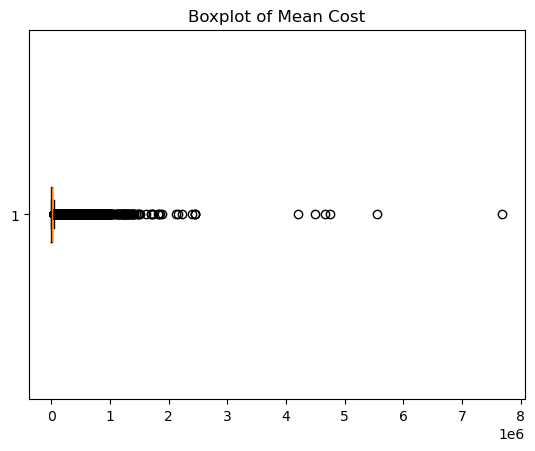

In [5]:
plt.boxplot(NY['Mean Cost'], vert=False)
plt.title('Boxplot of Mean Cost')
plt.show()

The boxplot shows that there is an extremely large number of outliers. These outliers are not only numerous but also located far from the main body of the data, with some values reaching over one million dollars.

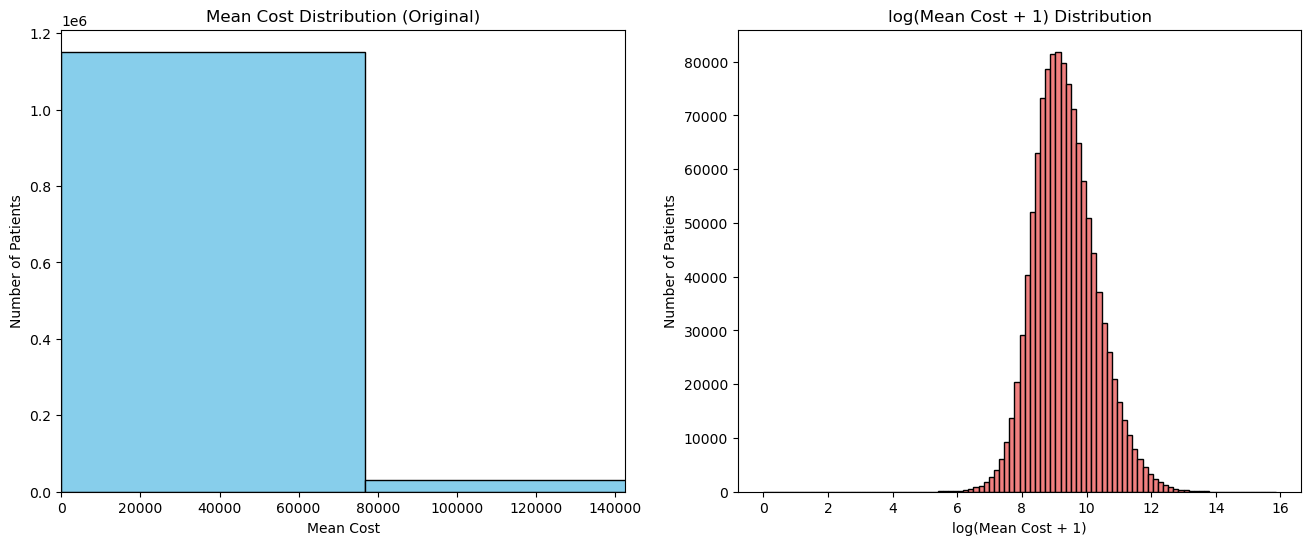

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Normal Mean Cost Distribution
axs[0].hist(NY['Mean Cost'], bins=100, color='skyblue', edgecolor='black')
axs[0].set_title('Mean Cost Distribution (Original)')
axs[0].set_xlabel('Mean Cost')
axs[0].set_ylabel('Number of Patients')
axs[0].set_xlim(0, NY['Mean Cost'].quantile(0.99))

# log(Mean Cost) Distribution
axs[1].hist(np.log1p(NY['Mean Cost']), bins=100, color='lightcoral', edgecolor='black')
axs[1].set_title('log(Mean Cost + 1) Distribution')
axs[1].set_xlabel('log(Mean Cost + 1)')
axs[1].set_ylabel('Number of Patients')
plt.show()

The left plot shows the distribution of raw Mean Cost values, which is highly right-skewed, meaning most patients have low costs while a few have extremely high costs.

The right plot shows the distribution after applying a log1p transformation, making the data much more symmetric and closer to a normal distribution.

This transformation helps the model train better by reducing the influence of extreme outliers.

In [39]:
print("Mean Cost_min:", NY['Mean Cost'].min())
print("Mean Cost_max:", NY['Mean Cost'].max())
print("Mean Cost_mean:", NY['Mean Cost'].mean())
print("Mean Cost_sd:", NY['Mean Cost'].std())

Mean Cost_min: 0.0
Mean Cost_max: 7683085.8
Mean Cost_mean: 19389.37457997243
Mean Cost_sd: 34933.25029950565


By calculating the minimum, maximum, mean, and standard deviation of Mean Cost, we understand the basic distribution of the data, which helps later in checking whether the model’s predictions fall within a reasonable range.

### Prepare to train the model

In [57]:
# Convert 'APR Medical Surgical Code' categorical variables to numerical
lebel = LabelEncoder()
NY['APR Medical Surgical Code'] = lebel.fit_transform(NY['APR Medical Surgical Code'])
# Select the feature columns to construct the input matrix X
X = NY[['Year', 'Facility Id', 'APR DRG Code', 'APR Severity of Illness Code',
        'APR Medical Surgical Code', 'Discharges', 'Mean Charge']]
# Define the target variable y
y = NY['Mean Cost']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Handle extreme outliers before model training
cost_clip_value = y_train.quantile(0.99)
charge_clip_value = X_train['Mean Charge'].quantile(0.99)
y_train = y_train.clip(upper=cost_clip_value)
X_train['Mean Charge'] = X_train['Mean Charge'].clip(upper=charge_clip_value)
# Help model fit better by stabilizing variance and reducing skewness
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

### Explore the correlation between features using Maximal Information Coefficient(MIC)

**Why we choose this method?**

Unlike Pearson correlation, which only detects linear correlation, MIC is a measure designed to capture both linear and nonlinear relationships between two variables. Its value ranges from 0(no relationship) to 1(have relationship).

In our dataset, the relationship between features (like Mean Charge, APR DRG Code) and the target (Mean Cost) is not strictly linear, as costs can be influenced by complex healthcare coding and billing structures. Thus, using MIC helps us better detect important variables that might have nonlinear but meaningful impacts on the outcome.

This output shows the MIC scores between each feature and the target variable (Mean Cost). A higher MIC score indicates a stronger relationship between the feature and the target.

In [9]:
# Features that we want to compute MIC scores
selected_features = [
    'Facility Id', 
    'APR DRG Code', 
    'APR Severity of Illness Code',
    'Year',
    'APR Medical Surgical Code',
    'Discharges',
    'Mean Charge'
]

# Compute MIC scores between features and the target
def compute_mic(X, y):
    mic_scores = {}
    mine = MINE(alpha=0.5)
    for col in selected_features:
        mine.compute_score(X[col], y)
        mic_scores[col] = mine.mic()
    return mic_scores

# Compute MIC scores on training data
mic_scores = compute_mic(X_train, y_train_log)

# Sort features by MIC scores in descending order
mic_sorted = sorted(mic_scores.items(), key=lambda x: x[1], reverse=True)
for feature, score in mic_sorted:
    print(f"{feature}: MIC={score:.4f}")

Mean Charge: MIC=0.5665
APR DRG Code: MIC=0.1918
APR Severity of Illness Code: MIC=0.1672
APR Medical Surgical Code: MIC=0.1099
Facility Id: MIC=0.1080
Discharges: MIC=0.0212
Year: MIC=0.0194


From the output, Mean Charge (MIC=0.5665) has the strongest relationship with Mean Cost, while features like Year (MIC=0.0194) and Discharges (MIC=0.0212) have very weak relationships.
This helps prioritize important features when building predictive models. We plan to exclude Year and Discharges from model training, as their weak correlations with the target may introduce noise and negatively impact model performance.

### Machine Learning Models- XGBoost
**Why we choose this model?**
XGBoost is well-suited for datasets like ours that contain many structured features, such as year, facility ID, and diagnosis codes. Since the distribution of Mean Cost in our data is highly skewed with some extreme high-cost cases, XGBoost’s built-in regularization and robustness help the model capture complex feature interactions while reducing the risk of overfitting.

In [45]:
# Define a grid of hyperparameters to search over
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [300, 500],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Initialize an XGBoost regressor model (no parameters set yet)
model = XGBRegressor()

# Set up GridSearchCV to search over the parameter grid
grid_search = GridSearchCV(
    model,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Perform the grid search on the training data (with log-transformed target)
grid_search.fit(X_train, y_train_log)
print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.8; total time=  14.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.8; total time=  14.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.8; total time=  14.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=300, subsample=0.8; total time=  19.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=300, subsample=0.8; total time=  20.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.8; total time=  21.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.8; total time=  21.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.8; total time=  21.8s
[CV] END co

Through the output, we first tried to work on these parameter: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}

In [47]:
# Initializes an XGBoost model with hyperparameters that provided optimized
best_model = XGBRegressor(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=8,
    n_estimators=500,
    subsample=0.8
)
# Train the XGBoost model on the log-transformed training data
best_model.fit(X_train, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [48]:
# Predict and convert results back to the original scale
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Calculate Mean Squared Error(mse),Root Mean Squared Error (RMSE), R squared
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-squared (R²): {r2:.4f}")

Test MSE: 610362587.21
Test RMSE: 24705.52
Test R-squared (R²): 0.5526


**MSE**: measures the average squared difference between the actual and predicted values — a lowe**r MSE indicates better model performance.

**RMSE**: square root of MSE — lower RMSE means better accuracy.

**R-squared**: 0-1 scores indicates the proportion of variance explained by the model — higher R² values represent better fit and predictive power.

From the output, the model achieves an R² of 0.5526, meaning it explains about 55% of the variability in the target variable, with an RMSE of approximately 24,705. We tried to figure how to increase the R² and reduce the RMSE for improved prediction performance.

#### Remove 'Discharges' and 'Year'

Utilize the insights discovered by MIC and train the model to see if removing weaker features can help reduce noise and improve model performance.

In [68]:
important_features = ['Mean Charge', 'APR DRG Code', 'APR Severity of Illness Code', 'APR Medical Surgical Code', 'Facility Id']
X_train_selected = X_train[selected_features].copy()
X_test_selected = X_test[important_features]

In [69]:
# Initializes an XGBoost model with hyperparameters that provided optimized
best_model = XGBRegressor(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=8,
    n_estimators=500,
    subsample=0.8
)

# Train the XGBoost model on the log-transformed training data
best_model.fit(X_train, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [71]:
# Predit the model
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Squared Error(mse),Root Mean Squared Error (RMSE), R squared again
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-squared (R²): {r2:.4f}")

Test MSE: 699290602.87
Test RMSE: 26444.10
Test R-squared (R²): 0.4874


Before removing 'Discharges' and 'Year', the model achieved a Test RMSE of 24,705.52 and a Test R² of 0.5526; after removing them, performance dropped (RMSE increased to 26,444.10 and R² fell to 0.4874), indicating that although these features had low MIC scores, they still contributed valuable information to the model.

Therefore, we will keep these two features and find another way to improve our predication.

#### Manually tuned hyperparameters

In [77]:
# Repeat previous code
X = NY[['Year', 'Facility Id', 'APR DRG Code', 'APR Severity of Illness Code',
        'APR Medical Surgical Code', 'Discharges', 'Mean Charge']]
y = NY['Mean Cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cost_clip_value = y_train.quantile(0.99)
charge_clip_value = X_train['Mean Charge'].quantile(0.99)
y_train = y_train.clip(upper=cost_clip_value)
X_train['Mean Charge'] = X_train['Mean Charge'].clip(upper=charge_clip_value)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

Setting objective='reg:squaredlogerror' in XGBoost changes the loss function to squared log error, which means the model minimizes the squared difference between the logarithm of predictions and the logarithm of actual values.
This is useful when Mean Cost is heavily skewed with large outliers, because log transformation compresses large values and stabilizes variance, making the model more robust:

In [96]:
best_model = XGBRegressor(
    colsample_bytree=0.6,
    learning_rate=0.2,
    max_depth=8,
    n_estimators=500,
    objective='reg:squaredlogerror',
    subsample=0.9
)
best_model.fit(X_train, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:squaredlogerror', ...)

In [97]:
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-squared (R²): {r2:.4f}")

Test MSE: 598644701.38
Test RMSE: 24467.22
Test R-squared (R²): 0.5612


This model achieved a lower RMSE (24,467.22 < 24,705.52), and a higher R-squared (0.5612 > 0.5526). This indicates that the manually tuned model fits the data slightly better and has better predictive accuracy.

Therefore, for the current stage of modeling, we will kepp this model performance and results.

#### XGBoost + LightGBM Ensemble

We apply an ensemble method that averages the predictions from XGBoost and LightGBM models. By combining two strong gradient boosting algorithms, we aim to leverage their complementary strengths and reduce individual model biases. 

In [80]:
# LightGBM regression model with specified hyperparameters
lgb_model = LGBMRegressor(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42
)

# Train the LightGBM model on the training set with log-transformed target
lgb_model.fit(X_train, y_train_log)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1006
[LightGBM] [Info] Number of data points in the train set: 953813, number of used features: 7
[LightGBM] [Info] Start training from score 9.337732


LGBMRegressor(colsample_bytree=0.6, max_depth=6, n_estimators=500,
              random_state=42, subsample=0.8)

In [82]:
# Predict on the test set using the trained XGBoost and LightGBM models
y_pred_xgb_log = best_model.predict(X_test)
y_pred_lgb_log = lgb_model.predict(X_test)

# Average the log-transformed predictions from both models
y_pred_log_ensemble = (y_pred_xgb_log + y_pred_lgb_log) / 2

# Reverse the log1p transformation to get the original scale predictions
y_pred_ensemble = np.expm1(y_pred_log_ensemble)

# Calculate mse, Rmse, and R-squared
mse = mean_squared_error(y_test, y_pred_ensemble)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_ensemble)
print(f"Ensemble (XGB + LGB) Test MSE: {mse:.2f}")
print(f"Ensemble (XGB + LGB) Test RMSE: {rmse:.2f}")
print(f"Ensemble (XGB + LGB) Test R²: {r2:.4f}")

Ensemble (XGB + LGB) Test MSE: 598177329.59
Ensemble (XGB + LGB) Test RMSE: 24457.66
Ensemble (XGB + LGB) Test R²: 0.5615


Although the ensemble model slightly improved the R-squared from 0.5612 to 0.5615, the gain is marginal and practically insignificant. This indicates that combining XGBoost and LightGBM did not introduce enough model diversity or complementary learning to meaningfully enhance performance. In this case, a single XGBoost model already captures most of the predictive patterns effectively. Therefore, we decide not to adopt the ensemble method and continue expore more possibilities for optimization.

#### Segmented Modeling

It's used to separately model different subgroups of the data — in this case, manually separating patients with extremely high Mean Charge (above $50,000) from normal patients.
The reason for doing this is that extreme outliers behave very differently from the majority of the data and can distort a single model's predictions.

By building two specialized models — one for normal patients and one for outliers — we are expecting to find more accurately in each group and improve overall prediction performance.

In [103]:
# Define a threshold to split the training data into high-cost and low-cost groups
threshold = 50000

# Create masks to separate patients
mask_high = y_train >= threshold
mask_low = y_train < threshold

# Split the training features and target variables based on costs
X_train_high = X_train[mask_high]
y_train_high = y_train_log[mask_high]
X_train_low = X_train[mask_low]
y_train_low = y_train_log[mask_low]

In [104]:
# Trian the model for normal patients distribution
model_low = XGBRegressor(
    colsample_bytree=0.6,
    learning_rate=0.2,
    max_depth=8,
    n_estimators=500,
    subsample=0.9,
    random_state=42
)
model_low.fit(X_train_low, y_train_low)

# Train the model for outlier patients distribution
model_high = XGBRegressor(
    colsample_bytree=0.6,
    learning_rate=0.2,
    max_depth=8,
    n_estimators=500,
    subsample=0.9,
    random_state=42
)
model_high.fit(X_train_high, y_train_high)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [105]:
# Apply the same threshold to split the test data into high-cost and low-cost groups
mask_test_high = X_test['Mean Charge'] >= threshold
mask_test_low = X_test['Mean Charge'] < threshold

# Predict separately using the corresponding models for each group
y_pred_low_log = model_low.predict(X_test[mask_test_low])
y_pred_high_log = model_high.predict(X_test[mask_test_high])

# Reverse the log1p transformation to get predictions in the original scale
y_pred_low = np.expm1(y_pred_low_log)
y_pred_high = np.expm1(y_pred_high_log)

# Combine the predictions from the two models into one final prediction array
y_pred_final = np.empty_like(y_test)
y_pred_final[mask_test_low.values] = y_pred_low
y_pred_final[mask_test_high.values] = y_pred_high

# Calculate mse, rmse, and R-squared
mse = mean_squared_error(y_test, y_pred_final)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_final)
print(f"Segmented Modeling Test MSE: {mse:.2f}")
print(f"Segmented Modeling Test RMSE: {rmse:.2f}")
print(f"Segmented Modeling Test R-squared (R²): {r2:.4f}")

Segmented Modeling Test MSE: 760948404.85
Segmented Modeling Test RMSE: 27585.29
Segmented Modeling Test R-squared (R²): 0.4422


Although Segmented Modeling was intended to separately handle high-cost and low-cost patients, this model performance was worse than the unified model we trained earlier. As a result, we chose to discard this approach and continue using the better-performing model.

#### Best Optimization - Two-stage Modeling

Two-stage Modeling is a method where we automatically split the data based on the 99th percentile of the training target (Mean Cost), treating extreme outliers separately. This approach avoids manual thresholding and allows the model to better handle heavy-tailed distributions. We chose this method because it improves overall prediction performance.

In [106]:
# repeat to split the dataset into training and testing sets(original one)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the 99th percentile threshold of the training target (Mean Cost)
threshold = y_train.quantile(0.99)

# Create a subset two samples
train_normal = X_train[y_train <= threshold]
y_train_normal = y_train[y_train <= threshold]
train_outliers = X_train[y_train > threshold]
y_train_outliers = y_train[y_train > threshold]

In [107]:
# Trian the model for normal patients distribution
model_normal = XGBRegressor(
    colsample_bytree=0.6,
    learning_rate=0.2,
    max_depth=8,
    n_estimators=500,
    subsample=0.9,
    random_state=42
)
model_normal.fit(train_normal, np.log1p(y_train_normal))

# Train the model for outlier patients distribution
model_outliers = XGBRegressor(
    colsample_bytree=0.6,
    learning_rate=0.2,
    max_depth=8,
    n_estimators=500,
    subsample=0.9,
    random_state=42
)
model_outliers.fit(train_outliers, np.log1p(y_train_outliers))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [108]:
# Predict on the test set using both the normal and outlier models
y_pred_normal_log = model_normal.predict(X_test)
y_pred_outliers_log = model_outliers.predict(X_test)

# Combine predictions:
# - If the normal model's prediction is below the threshold (in log space), use it
# - Otherwise, use the outlier model's prediction
y_pred_final_log = np.where(y_pred_normal_log <= np.log1p(threshold),
                            y_pred_normal_log,
                            y_pred_outliers_log)

# Apply inverse log1p transformation to get the final predicted cost values
y_pred_final = np.expm1(y_pred_final_log)

# Calculate mse, rmse, R-squared
mse = mean_squared_error(y_test, y_pred_final)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_final)
print(f"Two-stage Modeling Test MSE: {mse:.2f}")
print(f"Two-stage Modeling Test RMSE: {rmse:.2f}")
print(f"Two-stage Modeling Test R²: {r2:.4f}")

Two-stage Modeling Test MSE: 311477232.57
Two-stage Modeling Test RMSE: 17648.72
Two-stage Modeling Test R²: 0.7717


Compared to previous approaches, this model achieves the highest R² (best goodness-of-fit) and the lowest RMSE (smallest prediction errors). This demonstrates that the two-stage method, which separately models normal and outlier cases, significantly improves prediction accuracy.

**Therefore, we select this model as our final solution😄.**